
# Modified Bateman vs CRAM-16 — Toggleable Engines (with PyMC)
- `expected_counts_per_bin(..., engine="bateman"|"cram")` to switch engines.
- **CRAM-16** (Chebyshev Rational Approximation) for matrix exponentials.
- **Modified Bateman** engine and a **symbolic Bateman** (NUTS-capable).
- Two PyMC model builders:
  - `build_model_symbolic_bateman_nuts(...)`
  - `build_model_generic_op(..., engine=...)` (Slice/Metropolis)


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc as pm
import aesara
import aesara.tensor as at

%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
LN2 = np.log(2.0)


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Modified Bateman — engine

In [2]:

from math import isfinite, factorial

def modified_bateman_populations_at_times(times, T, R, N0):
    T = [0.0] + list(T)
    R = [0.0] + list(R)
    nn = 1
    for idx in range(1, len(T)):
        if T[idx] == 0: break
        nn = idx + 1
    k = [0.0]*nn
    for i in range(1, nn):
        if T[i] > 1e99 or not isfinite(T[i]): k[i] = 0.0
        else: k[i] = LN2 / T[i]
    times = np.asarray(times, dtype=float)
    out = np.zeros((len(times), nn), dtype=float); out[:,0] = times
    for i in range(1, nn):
        kd, mult = [], []
        for qi in range(1, i+1):
            lam = k[qi]
            merged=False
            for j in range(len(kd)):
                if abs(kd[j]-lam) <= 1e-15*max(1.0,abs(kd[j]),abs(lam)):
                    mult[j]+=1; merged=True; break
            if not merged: kd.append(lam); mult.append(1)
        me = len(kd)
        Nbr = 6.022e23
        for j in range(1, i):
            Nbr *= R[j] * (LN2/T[j] if (T[j] < 1e99 and isfinite(T[j])) else 0.0)
        for j in range(me):
            V = [0.0]*mult[j]
            denom_inv = 1.0
            for p in range(me):
                if p!=j: denom_inv /= (kd[p]-kd[j])**mult[p]
            V[0] = denom_inv
            for m in range(1, mult[j]):
                S_acc = 0.0
                for h in range(m):
                    S = 0.0
                    for p in range(me):
                        if p!=j: S += mult[p]/(kd[p]-kd[j])**(h+1)
                    S_acc += V[m-1-h]*S / factorial(m-1-h)
                V[m] = S_acc*factorial(m-1)
            sign = -1 if (mult[j]-1)%2==1 else 1
            for it, tt in enumerate(times):
                S = 0.0
                for m in range(mult[j]):
                    S += V[m]*((-tt)**(mult[j]-1-m))/(factorial(mult[j]-1-m)*factorial(m))
                out[it,i] += S*np.exp(-kd[j]*tt)*sign
        out[:,i] *= Nbr
    return out

def total_activity_bateman_parent_plus_daughters(times, A0, parentT, d0, d1, d2, b_vec, include_parent=True):
    t = np.asarray(times, dtype=float)
    lam_p = LN2/parentT; lam0 = LN2/d0; lam1 = LN2/d1; lam2 = LN2/d2
    A = np.zeros_like(t, dtype=float)
    if include_parent:
        A += lam_p * A0 * np.exp(-lam_p*t)
    for lam_d, Td, b in zip([lam0,lam1,lam2],[d0,d1,d2], b_vec):
        if b <= 0: continue
        delta = lam_d - lam_p
        common = np.exp(-lam_p*t) - np.exp(-lam_d*t)
        expr = A0*b*lam_d*(lam_p/delta)*common
        expr_lim = A0*b*(lam_p**2)*t*np.exp(-lam_p*t)
        A += np.where(np.abs(delta)<1e-12, expr_lim, expr)
    return A

def expected_counts_per_bin_bateman(centers_s, bin_width_s, A0, parentT, d0, d1, d2, b_vec,
                                    background_rate=0.0, oversample=1):
    c = np.asarray(centers_s, dtype=float); dt = float(bin_width_s)
    if oversample<=1:
        rate = total_activity_bateman_parent_plus_daughters(c, A0,parentT,d0,d1,d2,b_vec, True) + background_rate
        return rate*dt
    out = np.empty_like(c)
    for i, tc in enumerate(c):
        t0, t1 = tc-0.5*dt, tc+0.5*dt
        ts = np.linspace(t0, t1, oversample+1)
        rate = total_activity_bateman_parent_plus_daughters(ts, A0,parentT,d0,d1,d2,b_vec, True) + background_rate
        out[i] = np.trapz(rate, ts)
    return out


## CRAM-16 — engine

In [3]:

theta = np.array([
    -1.0843917078696988026e+01 + 1.9277446167181652284e+01j,
    -5.2649713434426468895e+00 + 1.6220221473167927305e+01j,
     5.9481522689511774808e+00 + 3.5874573620183222829e+00j,
     3.5091036084149180974e+00 + 8.4361989858843750826e+00j,
     6.4161776990994341923e+00 + 1.1941223933701386874e+00j,
     1.4193758971856659786e+00 + 1.0925363484496722585e+01j,
     4.9931747377179963991e+00 + 5.9968817136039422260e+00j,
    -1.4139284624888862114e+00 + 1.3497725698892745389e+01j
], dtype=np.complex128)

alpha = np.array([
    -5.0901521865224915650e-07 - 2.4220017652852287970e-05j,
     2.1151742182466030907e-04 + 4.3892969647380673918e-03j,
     1.1339775178483930527e+02 + 1.0194721704215856450e+02j,
     1.5059585270023467528e+01 - 5.7514052776421819979e+00j,
    -6.4500878025539646595e+01 - 2.2459440762652096056e+02j,
    -1.4793007113557999718e+00 + 1.7686588323782937906e+00j,
    -6.2518392463207918892e+01 - 1.1190391094283228480e+01j,
     4.1023136835410021273e-02 - 1.5743466173455468191e-01j
], dtype=np.complex128)

alpha0 = 2.1248537104952237488e-16

def cram16_expm_action(A, t, x0):
    n = A.shape[0]
    M = (A*t).astype(np.complex128, copy=False)
    I = np.eye(n, dtype=np.complex128)
    y = alpha0 * x0.astype(np.complex128)
    for th, al in zip(theta, alpha):
        yj = np.linalg.solve(M - th*I, x0)
        y += 2.0*np.real(al * yj)
    return np.real(y)

def decay_matrix_parent_3daughters(parentT, d0, d1, d2, b_vec):
    lam_p = LN2/parentT; lam0 = LN2/d0; lam1 = LN2/d1; lam2 = LN2/d2
    b0,b1,b2 = b_vec
    A = np.array([
        [-lam_p,    0.0,    0.0,    0.0],
        [ b0*lam_p,-lam0,   0.0,    0.0],
        [ b1*lam_p, 0.0,  -lam1,    0.0],
        [ b2*lam_p, 0.0,    0.0,  -lam2],
    ], dtype=float)
    return A, lam_p, lam0, lam1, lam2

def expected_counts_per_bin_cram(centers_s, bin_width_s, A0, parentT, d0, d1, d2, b_vec,
                                 background_rate=0.0, oversample=1):
    A, lam_p, lam0, lam1, lam2 = decay_matrix_parent_3daughters(parentT, d0, d1, d2, b_vec)
    c = np.asarray(centers_s, dtype=float); dt = float(bin_width_s)
    out = np.empty_like(c)
    x0 = np.array([A0,0,0,0], dtype=float)
    if oversample<=1:
        for i, t in enumerate(c):
            N = cram16_expm_action(A, t, x0)
            rate = lam_p*N[0] + lam0*N[1] + lam1*N[2] + lam2*N[3] + background_rate
            out[i] = rate*dt
        return out
    for i, tc in enumerate(c):
        t0, t1 = tc-0.5*dt, tc+0.5*dt
        ts = np.linspace(t0, t1, oversample+1)
        rates = []
        for t in ts:
            N = cram16_expm_action(A, t, x0)
            rate = lam_p*N[0] + lam0*N[1] + lam1*N[2] + lam2*N[3] + background_rate
            rates.append(rate)
        out[i] = np.trapz(rates, ts)
    return out


## Unified wrapper

In [4]:

def expected_counts_per_bin(centers_s, bin_width_s, A0, parentT, d0, d1, d2, b_vec,
                            background_rate=0.0, oversample=1, engine="bateman"):
    engine = engine.lower()
    if engine == "bateman":
        return expected_counts_per_bin_bateman(centers_s, bin_width_s, A0,parentT,d0,d1,d2,b_vec,
                                               background_rate=background_rate, oversample=oversample)
    elif engine == "cram":
        return expected_counts_per_bin_cram(centers_s, bin_width_s, A0,parentT,d0,d1,d2,b_vec,
                                            background_rate=background_rate, oversample=oversample)
    else:
        raise ValueError("engine must be 'bateman' or 'cram'")


## PyMC model (NUTS-friendly) — symbolic Bateman

In [5]:

def _daughter_activity_symbolic(t, A0, b, lam_p, lam_d):
    delta = lam_d - lam_p
    common = at.exp(-lam_p*t) - at.exp(-lam_d*t)
    expr     = A0 * b * lam_d * (lam_p/delta) * common
    expr_lim = A0 * b * (lam_p**2) * t * at.exp(-lam_p*t)
    return at.switch(at.abs_(delta) < 1e-12, expr_lim, expr)

def expected_counts_symbolic_bateman(centers_s, width_s, A0, parentT, d0, d1, d2, b_vec, bg_rate):
    t = centers_s
    lam_p = LN2/parentT; lam0 = LN2/d0; lam1 = LN2/d1; lam2 = LN2/d2
    A_parent = lam_p * A0 * at.exp(-lam_p*t)
    A_0n = _daughter_activity_symbolic(t, A0, b_vec[0], lam_p, lam0)
    A_1n = _daughter_activity_symbolic(t, A0, b_vec[1], lam_p, lam1)
    A_2n = _daughter_activity_symbolic(t, A0, b_vec[2], lam_p, lam2)
    A_total = A_parent + A_0n + A_1n + A_2n + bg_rate
    return A_total * width_s

def build_model_symbolic_bateman_nuts(bin_centers_s, bin_width_s, y_counts, priors=None):
    priors = priors or {}
    c = at.as_tensor_variable(np.asarray(bin_centers_s, dtype=float))
    w = float(bin_width_s)
    y = np.asarray(y_counts, dtype=int)

    with pm.Model() as model:
        A0 = pm.HalfNormal("A0", sigma=priors.get("A0_sigma", 1e10))
        parentT = pm.LogNormal("parentT", mu=np.log(priors.get("parentT_mu", 0.008)), sigma=priors.get("parentT_sigma", 0.5))
        d0 = pm.LogNormal("daugh0nT", mu=np.log(priors.get("d0_mu", 0.0064)), sigma=priors.get("d0_sigma", 0.2))
        d1 = pm.LogNormal("daugh1nT", mu=np.log(priors.get("d1_mu", 0.0072)), sigma=priors.get("d1_sigma", 0.2))
        d2 = pm.LogNormal("daugh2nT", mu=np.log(priors.get("d2_mu", 0.0114)), sigma=priors.get("d2_sigma", 0.2))

        logits = pm.Normal("logits", mu=priors.get("logits_mu", 0.0), sigma=priors.get("logits_sigma", 2.0), shape=3)
        b = pm.Deterministic("b", at.nnet.softmax(logits))

        bg = pm.HalfNormal("backgroundRate", sigma=priors.get("bg_sigma", 1e6))

        mu = expected_counts_symbolic_bateman(c, w, A0, parentT, d0, d1, d2, b, bg)
        y_obs = pm.Poisson("y_obs", mu=mu, observed=y)
    return model


## PyMC model (generic Op) — choose engine='bateman' or 'cram'

In [6]:

from aesara.graph.op import Op

class ExpectedCountsOp(Op):
    itypes = [aesara.tensor.dvector, aesara.tensor.dscalar,  # centers, width
              aesara.tensor.dscalar, aesara.tensor.dscalar,  # A0, parentT
              aesara.tensor.dscalar, aesara.tensor.dscalar, aesara.tensor.dscalar,  # d0,d1,d2
              aesara.tensor.dvector,  # b
              aesara.tensor.dscalar]  # bg
    otypes = [aesara.tensor.dvector]
    def __init__(self, engine="bateman"):
        self.engine = engine
        super().__init__()
    def perform(self, node, inputs, outputs):
        centers, width, A0_, parentT_, d0_, d1_, d2_, b_arr, bg_ = inputs
        lam = expected_counts_per_bin(
            centers, float(width), float(A0_), float(parentT_), float(d0_), float(d1_), float(d2_),
            np.array([float(b_arr[0]), float(b_arr[1]), float(b_arr[2])], dtype=float),
            background_rate=float(bg_), oversample=1, engine=self.engine
        )
        outputs[0][0] = lam.astype(np.float64)

def build_model_generic_op(bin_centers_s, bin_width_s, y_counts, priors=None, engine="bateman"):
    priors = priors or {}
    centers = np.asarray(bin_centers_s, dtype=float)
    width = float(bin_width_s)
    y = np.asarray(y_counts, dtype=int)

    with pm.Model() as model:
        A0 = pm.HalfNormal("A0", sigma=priors.get("A0_sigma", 1e10))
        parentT = pm.LogNormal("parentT", mu=np.log(priors.get("parentT_mu", 0.008)), sigma=priors.get("parentT_sigma", 0.5))
        d0 = pm.LogNormal("daugh0nT", mu=np.log(priors.get("d0_mu", 0.0064)), sigma=priors.get("d0_sigma", 0.2))
        d1 = pm.LogNormal("daugh1nT", mu=np.log(priors.get("d1_mu", 0.0072)), sigma=priors.get("d1_sigma", 0.2))
        d2 = pm.LogNormal("daugh2nT", mu=np.log(priors.get("d2_mu", 0.0114)), sigma=priors.get("d2_sigma", 0.2))

        logits = pm.Normal("logits", mu=priors.get("logits_mu", 0.0), sigma=priors.get("logits_sigma", 2.0), shape=3)
        b = pm.Deterministic("b", at.nnet.softmax(logits))

        bg = pm.HalfNormal("backgroundRate", sigma=priors.get("bg_sigma", 1e6))

        centers_data = pm.MutableData("bin_centers_s", centers)
        width_data   = pm.MutableData("bin_width_s", np.array(width, dtype=float))

        exp_counts = ExpectedCountsOp(engine=engine)(centers_data, width_data, A0, parentT, d0, d1, d2, b, bg)
        y_obs = pm.Poisson("y_obs", mu=exp_counts, observed=y)
    return model


## Synthetic demo + engine comparison

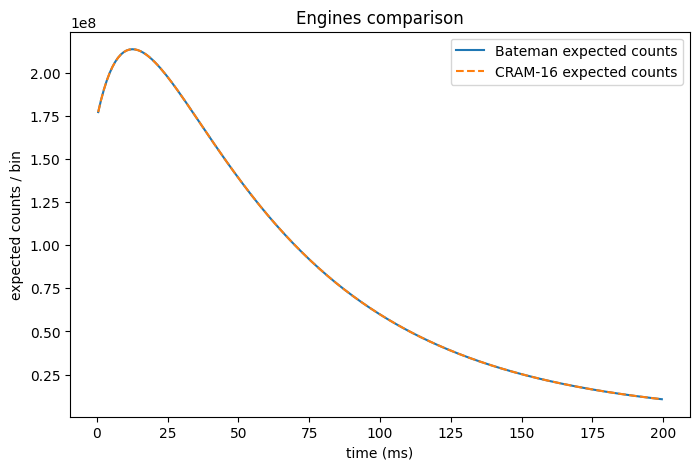

In [7]:

# Synthetic data: 1 ms bins, 0..200 ms
bin_centers_ms = np.arange(0.5, 200.5, 1.0)
bin_width_ms = 1.0
bin_centers_s = bin_centers_ms * 1e-3
bin_width_s   = bin_width_ms * 1e-3

true = dict(A0=1e10, parentT=0.040, d0=0.0064, d1=0.0072, d2=0.0114, b0=0.00, b1=0.51, b2=0.24, bg=5.0)
b_vec_true = np.array([true["b0"], true["b1"], true["b2"]], dtype=float)

lam_bateman = expected_counts_per_bin(bin_centers_s, bin_width_s, true["A0"], true["parentT"],
                                      true["d0"], true["d1"], true["d2"], b_vec_true,
                                      background_rate=true["bg"], engine="bateman")
lam_cram    = expected_counts_per_bin(bin_centers_s, bin_width_s, true["A0"], true["parentT"],
                                      true["d0"], true["d1"], true["d2"], b_vec_true,
                                      background_rate=true["bg"], engine="cram")

plt.plot(bin_centers_ms, lam_bateman, label="Bateman expected counts")
plt.plot(bin_centers_ms, lam_cram, "--", label="CRAM-16 expected counts")
plt.xlabel("time (ms)"); plt.ylabel("expected counts / bin"); plt.title("Engines comparison")
plt.legend(); plt.show()

rng = np.random.default_rng(7)
y_counts = rng.poisson(lam_bateman)

priors = dict(
    A0_sigma=1e11,
    parentT_mu=0.05, parentT_sigma=0.6,
    d0_mu=0.0064, d0_sigma=0.2,
    d1_mu=0.0072, d1_sigma=0.2,
    d2_mu=0.0114, d2_sigma=0.2,
    logits_mu=0.0, logits_sigma=2.0,
    bg_sigma=100.0
)


### Sample with NUTS (symbolic Bateman) — uncomment to run

In [ ]:
engine_choice = "cram"   # or "bateman"
model_nuts = build_model_symbolic_bateman_nuts(bin_centers_s, bin_width_s, y_counts, priors=priors, engine=engine_choice)
with model_nuts:
    idata_nuts = pm.sample(2000, tune=1000, target_accept=0.95, chains=4, cores=4, random_seed=42)
idata_nuts


### Sample with Slice/Metropolis (generic Op) — engine="bateman" or "cram"

In [ ]:

# engine_choice = "cram"   # or "bateman"
# model_op = build_model_generic_op(bin_centers_s, bin_width_s, y_counts, priors=priors, engine=engine_choice)
# with model_op:
#     idata_op = pm.sample(2000, tune=1000, chains=4, cores=1, step=pm.Slice(), random_seed=42)
# idata_op


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import aesara.tensor as at
# Load the tab-separated file
df = pd.read_csv("hist_33Na_with_error.csv", sep="\t")
df = df.rename(columns={"# BinCenter": "BinCenter"})
df["BinContent"] = df["BinContent"].str.replace(",", "").astype(float)
df["BinError"] = df["BinError"].str.replace(",", "").astype(float)
df.head() 
# Compute original bin width
diffs = df["BinCenter"].diff().dropna().unique()
bin_width = round(diffs[0], 5)
print(f"Original bin width: {bin_width} ms")

# Set desired bin width (user can modify this value)
desired_bin_width = 2
rebin_factor = int(desired_bin_width / bin_width)

if len(df) % rebin_factor != 0:
    df = df.iloc[:-(len(df) % rebin_factor)]

# Rebin data
df_rebinned = df.groupby(np.arange(len(df)) // rebin_factor).agg({
    "BinCenter": "mean",
    "BinContent": "sum",
    "BinError": lambda x: np.sqrt(np.sum(x**2))
}).reset_index(drop=True)

df_rebinned.head()



Original bin width: 0.5 ms


,BinCenter,BinContent,BinError
0,-99.0,10355.0,101.759547
1,-97.0,10607.0,102.990256
2,-95.0,10355.0,101.759516
3,-93.0,10352.0,101.744793
4,-91.0,10354.0,101.754573


/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1119: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  FutureWarning,
/projects/e21062/tg/venv/lib/python3.7/site-packages/aesara/tensor/nnet/basic.py:1128: UserWarning: Softmax no longer converts a vector to a row matrix.
  UserWarning,
Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [A0]
>Slice: [parentT]
>Slice: [daugh0nT]
>Slice: [daugh1nT]
>Slice: [daugh2nT]
>Slice: [logits]
>Slice: [backgroundRate]


/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in add
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:72: 

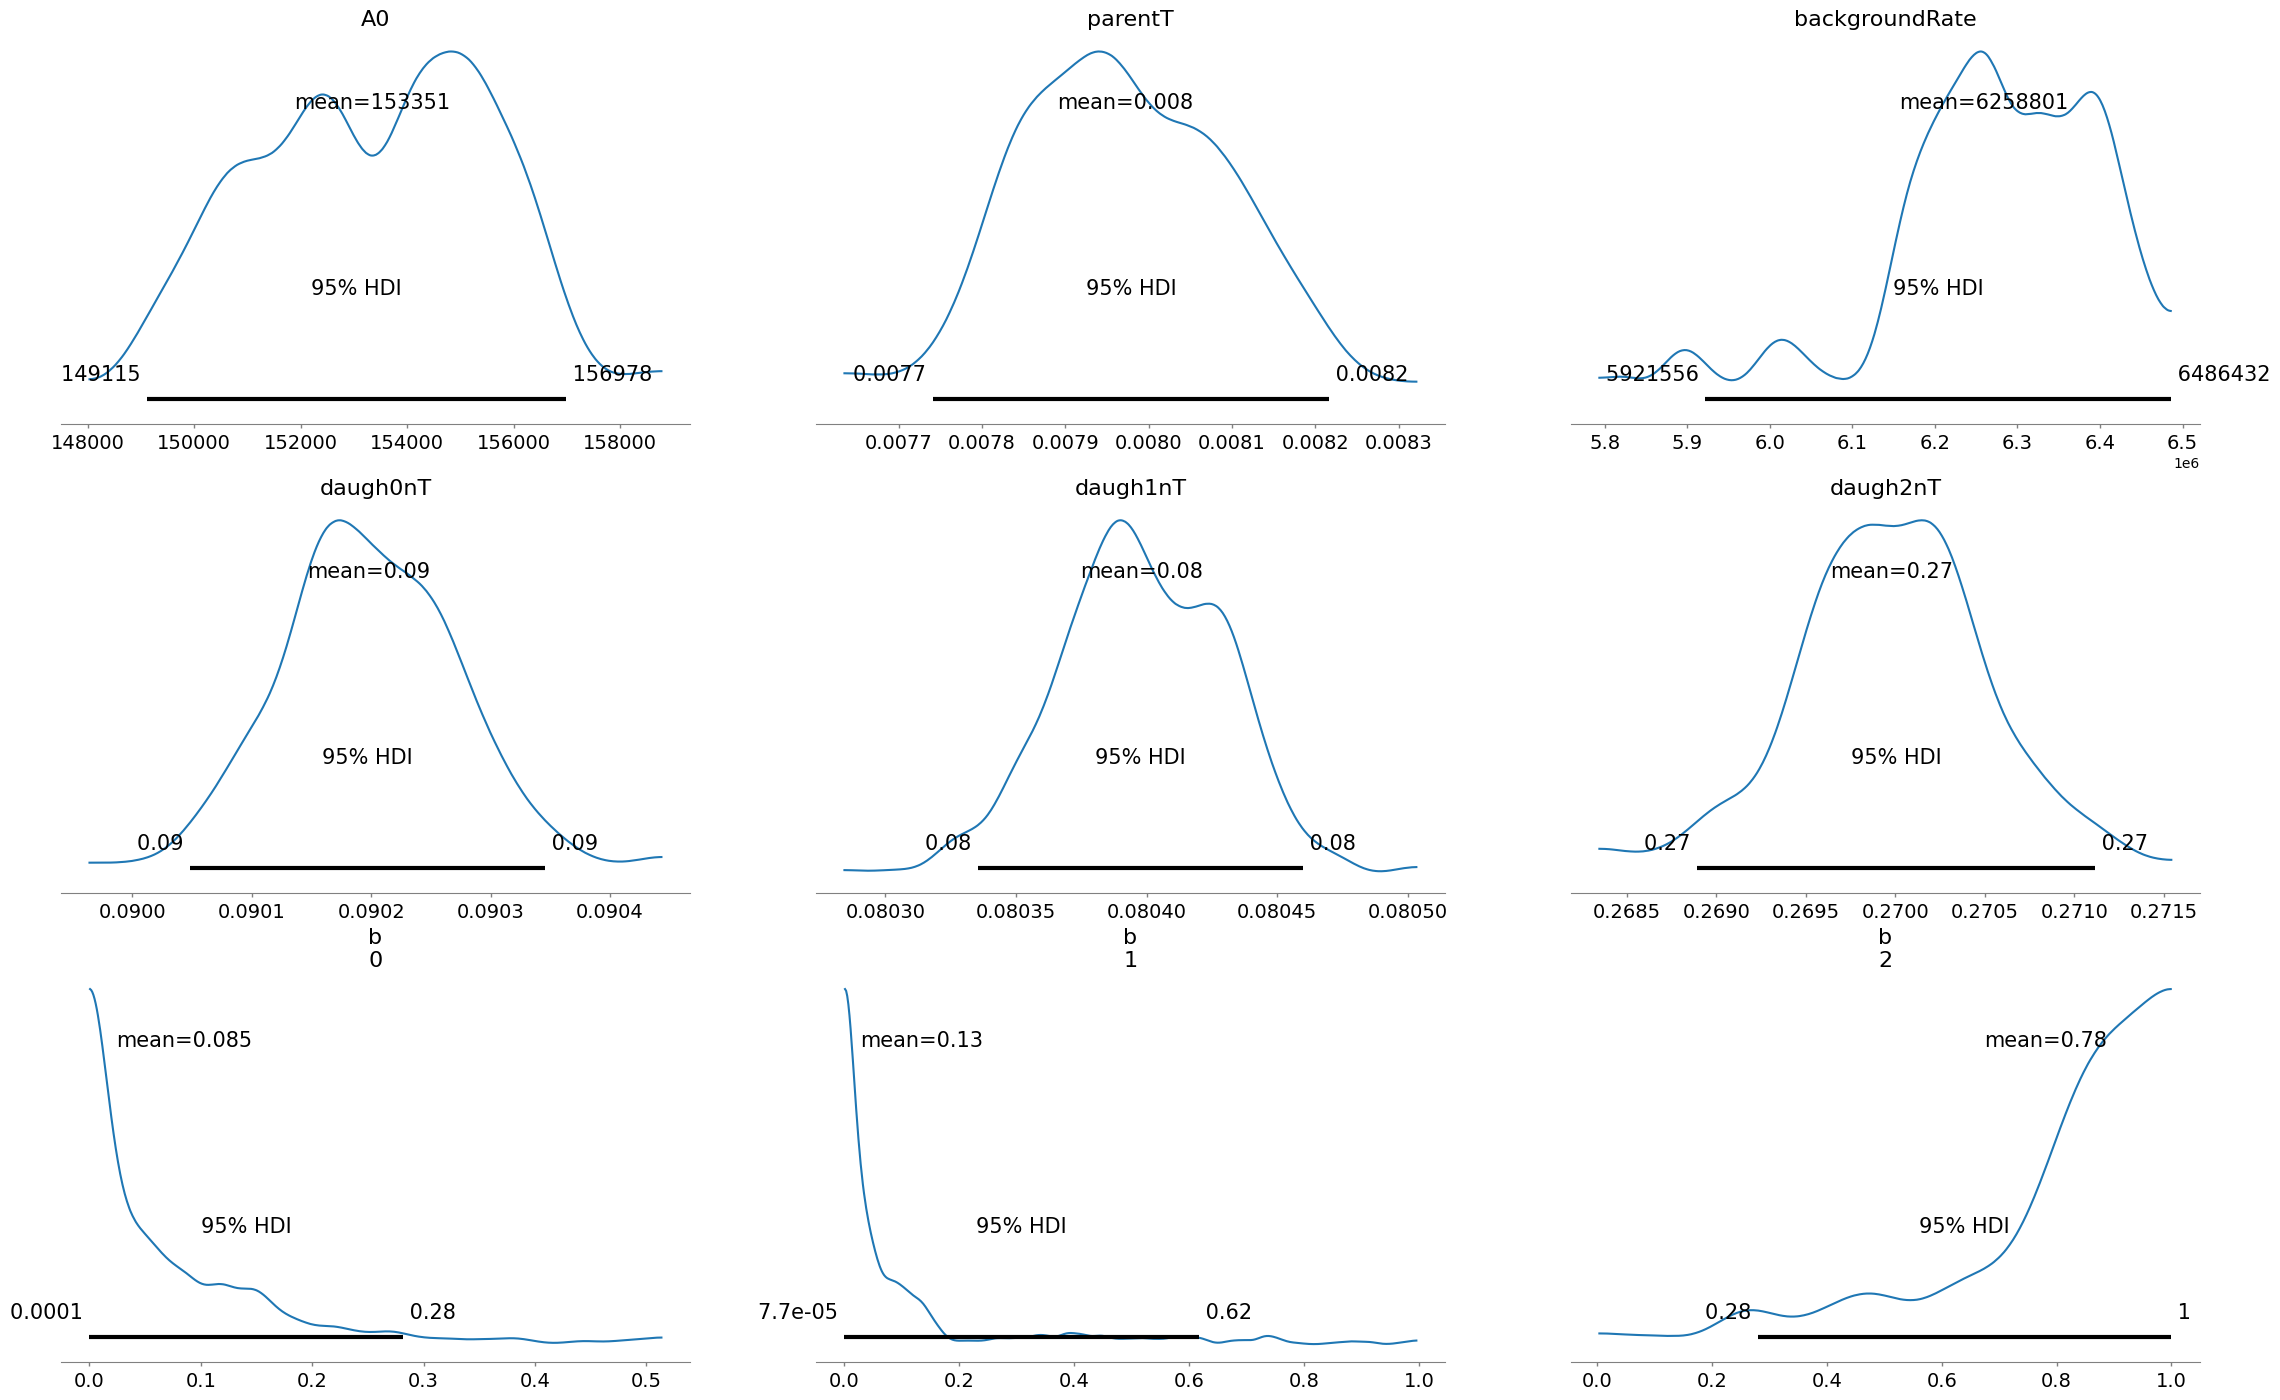

KeyError: 'y_obs'

In [17]:
# ==========================================
# CRAM-16 expected counts + PyMC (Slice)
# ==========================================
import numpy as np
import pymc as pm
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt

# -------- 0) Prep arrays from your df_rebinned --------
df_pos = df_rebinned[df_rebinned["BinCenter"] >= 0].copy()
df_pos=df_pos[df_pos["BinCenter"] <= 40] 
centers_ms = df_pos["BinCenter"].to_numpy(float)
counts     = np.clip(np.round(df_pos["BinContent"].to_numpy(float)), 0, None).astype(int)

# Bin width (ms) — use your desired_bin_width if defined, else infer
try:
    width_ms = float(desired_bin_width)
except NameError:
    diffs = df_rebinned["BinCenter"].diff().dropna().unique()
    width_ms = float(np.round(diffs[0], 5))

centers_s = centers_ms * 1e-3
width_s   = width_ms * 1e-3
LN2 = np.log(2.0)

# -------- 1) Background prior scale from t<0 (counts/s) --------
neg = df_rebinned[df_rebinned["BinCenter"] < 0]
if len(neg) > 0:
    bg_per_bin = float(neg["BinContent"].mean())
else:
    k = max(1, int(0.1 * len(df_pos)))
    bg_per_bin = float(df_pos["BinContent"].tail(k).mean())
bg_rate_mu = bg_per_bin / width_s
bg_sigma   = max(bg_rate_mu * 2.0, 1.0)   # HalfNormal scale

# -------- 2) CRAM-16 constants + engine (NumPy) --------
# Order-16 Chebyshev rational approximation coefficients (Pusa, corrected)
theta = np.array([
    -1.0843917078696988026e+01 + 1.9277446167181652284e+01j,
    -5.2649713434426468895e+00 + 1.6220221473167927305e+01j,
     5.9481522689511774808e+00 + 3.5874573620183222829e+00j,
     3.5091036084149180974e+00 + 8.4361989858843750826e+00j,
     6.4161776990994341923e+00 + 1.1941223933701386874e+00j,
     1.4193758971856659786e+00 + 1.0925363484496722585e+01j,
     4.9931747377179963991e+00 + 5.9968817136039422260e+00j,
    -1.4139284624888862114e+00 + 1.3497725698892745389e+01j
], dtype=np.complex128)

alpha = np.array([
    -5.0901521865224915650e-07 - 2.4220017652852287970e-05j,
     2.1151742182466030907e-04 + 4.3892969647380673918e-03j,
     1.1339775178483930527e+02 + 1.0194721704215856450e+02j,
     1.5059585270023467528e+01 - 5.7514052776421819979e+00j,
    -6.4500878025539646595e+01 - 2.2459440762652096056e+02j,
    -1.4793007113557999718e+00 + 1.7686588323782937906e+00j,
    -6.2518392463207918892e+01 - 1.1190391094283228480e+01j,
     4.1023136835410021273e-02 - 1.5743466173455468191e-01j
], dtype=np.complex128)

alpha0 = 2.1248537104952237488e-16  # real

def cram16_expm_action(A, t, x0):
    """y ≈ exp(A t) x0 using CRAM-16; A real (n,n), x0 real (n,)"""
    n = A.shape[0]
    M = (A * t).astype(np.complex128, copy=False)
    I = np.eye(n, dtype=np.complex128)
    y = alpha0 * x0.astype(np.complex128)
    for th, al in zip(theta, alpha):
        yj = np.linalg.solve(M - th * I, x0)
        y += 2.0 * np.real(al * yj)
    return np.real(y)

def decay_matrix_parent_3daughters(parentT, d0, d1, d2, b_vec):
    """State order: [parent, d0, d1, d2] with branching at parent."""
    lam_p = LN2/parentT; lam0 = LN2/d0; lam1 = LN2/d1; lam2 = LN2/d2
    b0, b1, b2 = b_vec
    A = np.array([
        [-lam_p,     0.0,    0.0,    0.0],
        [ b0*lam_p, -lam0,   0.0,    0.0],
        [ b1*lam_p,  0.0,  -lam1,    0.0],
        [ b2*lam_p,  0.0,    0.0,  -lam2],
    ], dtype=float)
    return A, lam_p, lam0, lam1, lam2

def expected_counts_per_bin_cram(centers_s, bin_width_s,
                                 A0, parentT, d0, d1, d2, b_vec,
                                 background_rate=0.0, oversample=1):
    A, lam_p, lam0, lam1, lam2 = decay_matrix_parent_3daughters(parentT, d0, d1, d2, b_vec)
    c = np.asarray(centers_s, dtype=float); dt = float(bin_width_s)
    out = np.empty_like(c)
    x0 = np.array([A0, 0.0, 0.0, 0.0], dtype=float)
    if oversample <= 1:
        for i, t in enumerate(c):
            N = cram16_expm_action(A, t, x0)
            rate = lam_p*N[0] + lam0*N[1] + lam1*N[2] + lam2*N[3] + background_rate
            out[i] = rate * dt
        return out
    # trapezoid inside each bin
    for i, tc in enumerate(c):
        t0, t1 = tc - 0.5*dt, tc + 0.5*dt
        ts = np.linspace(t0, t1, oversample+1)
        rates = []
        for t in ts:
            N = cram16_expm_action(A, t, x0)
            rates.append(lam_p*N[0] + lam0*N[1] + lam1*N[2] + lam2*N[3] + background_rate)
        out[i] = np.trapz(rates, ts)
    return out

# -------- 3) PyMC model that calls CRAM via a custom Op (use Slice/Metropolis) --------
from aesara.graph.op import Op

class ExpectedCountsCRAMOp(Op):
    itypes = [aesara.tensor.dvector, aesara.tensor.dscalar,  # centers, width
              aesara.tensor.dscalar, aesara.tensor.dscalar,  # A0, parentT
              aesara.tensor.dscalar, aesara.tensor.dscalar, aesara.tensor.dscalar,  # d0,d1,d2
              aesara.tensor.dvector,  # b (len=3)
              aesara.tensor.dscalar]  # bg
    otypes = [aesara.tensor.dvector]
    def perform(self, node, inputs, outputs):
        centers, width, A0_, parentT_, d0_, d1_, d2_, b_arr, bg_ = inputs
        lam = expected_counts_per_bin_cram(
            centers, float(width), float(A0_), float(parentT_),
            float(d0_), float(d1_), float(d2_),
            np.array([float(b_arr[0]), float(b_arr[1]), float(b_arr[2])], dtype=float),
            background_rate=float(bg_), oversample=1
        )
        outputs[0][0] = lam.astype(np.float64)

def build_model_cram(bin_centers_s, bin_width_s, y_counts, priors=None):
    priors = priors or {}
    centers = np.asarray(bin_centers_s, dtype=float)
    width   = float(bin_width_s)
    y = np.asarray(y_counts, dtype=int)

    with pm.Model() as model:
        A0 = pm.HalfNormal("A0", sigma=priors.get("A0_sigma", max(1.0, y.max()*10)))
        parentT = pm.LogNormal("parentT", mu=np.log(priors.get("parentT_mu", 8.2e-3)),
                               sigma=priors.get("parentT_sigma", 0.10))
        d0 = pm.LogNormal("daugh0nT", mu=np.log(priors.get("d0_mu", 90.2e-3)),
                          sigma=priors.get("d0_sigma", 0.10))
        d1 = pm.LogNormal("daugh1nT", mu=np.log(priors.get("d1_mu", 80.4e-3)),
                          sigma=priors.get("d1_sigma", 0.05))
        d2 = pm.LogNormal("daugh2nT", mu=np.log(priors.get("d2_mu", 270e-3)),
                          sigma=priors.get("d2_sigma", 0.03))

        logits = pm.Normal("logits", mu=priors.get("logits_mu", 0.0),
                           sigma=priors.get("logits_sigma", 2.0), shape=3)
        b = pm.Deterministic("b", at.nnet.softmax(logits))

        bg = pm.HalfNormal("backgroundRate", sigma=priors.get("bg_sigma", bg_sigma))

        centers_data = pm.MutableData("bin_centers_s", centers)
        width_data   = pm.MutableData("bin_width_s", np.array(width, dtype=float))

        mu = ExpectedCountsCRAMOp()(centers_data, width_data, A0, parentT, d0, d1, d2, b, bg)
        y_obs = pm.Poisson("y_obs", mu=mu, observed=y)
    return model

# -------- 4) Build + sample (Slice) --------
priors = dict(
    A0_sigma = max(1.0, counts.max()*10),
    parentT_mu = 8.2e-3, parentT_sigma = 40e-3,
    d0_mu = 90.2e-3,     d0_sigma = 0.9e-3,
    d1_mu = 80.4e-3,     d1_sigma = 0.4e-3,
    d2_mu = 270e-3,      d2_sigma = 2.0e-3,
    logits_mu = 0.0,     logits_sigma = 2.0,
    bg_sigma = bg_sigma
)

model_cram = build_model_cram(centers_s, width_s, counts, priors=priors)

with model_cram:
    idata_cram = pm.sample(
        draws=200, tune=100, chains=4, cores=4,   # cores=1 safer with custom Op
        step=pm.Slice(), random_seed=42, return_inferencedata=True
    )

# -------- 5) Posterior + time-series PPC --------
# Plot posteriors (b has length 3)
az.plot_posterior(
    idata_cram, var_names=["A0","parentT","backgroundRate","daugh0nT","daugh1nT","daugh2nT","b"],
    coords={"b_dim_0":[0,1,2]}, hdi_prob=0.95, point_estimate="mean"
)
plt.show()

# Posterior predictive per-bin
with model_cram:
    ppc = pm.sample_posterior_predictive(idata_cram, var_names=["y_obs"], random_seed=1)

y_pp = ppc["y_obs"]
lo, hi = np.percentile(y_pp, [5, 95], axis=0)
mean = y_pp.mean(axis=0)

plt.figure(figsize=(9,4.8))
plt.fill_between(centers_ms, lo, hi, alpha=0.25, label="PPC 90% band")
plt.plot(centers_ms, mean, "--", label="PPC mean")
plt.step(centers_ms, counts, where="mid", color="k", lw=1.2, label="Observed")
plt.xlabel("time (ms)"); plt.ylabel("counts / bin"); plt.title("CRAM-16 PPC")
plt.legend(); plt.show()
